In [1]:
# Import the necessary classes
import deribit_data
from deribit_data import Deribit_Options
from uniswap_data import Uniswap_Pool
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew, kurtosis, pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import coint
import requests

In [2]:
plt.style.use('panoptic-dark-16_9.mplstyle')

In [3]:
# Parameters for the Uniswap pool
token_0 = 'USDC'  # Stablecoin for example
token_1 = 'ETH'   # Ethereum
fee = 5          # 5 bps fee or 1, 30 or 100 
start = '2024-10-01'  # Start date in string
end = '2024-11-15'    # End date in string
window = 60 * 60 * 24  # 1 day window
inverse_price = True   # If True, price in terms of token_0 (USDC/ETH), else ETH/USDC

# Initialize the Uniswap Pool object
pool_data = Uniswap_Pool(token_0, token_1, fee, start, end, window, inverse_price)

# Load data (data is fetched inside Uniswap_Pool class)
print("Data loaded successfully!")

Loading Data...
Downloading: 100%|██████████|
Data loaded successfully!


## ETH DATA

### Uniwap

In [ ]:
# Extract ETH prices from the data (no need because we saved the csv already) using the previous cell code
eth_prices = pool_data.data['price']  

In [11]:
eth_uniswap=pd.read_csv('eth_uniswap_hourly')
eth_uniswap

,timestamp,price
0,2024-03-20 00:00:00+00:00,3193.485287
1,2024-03-20 01:00:00+00:00,3185.060383
2,2024-03-20 02:00:00+00:00,3207.085515
3,2024-03-20 03:00:00+00:00,3222.009220
4,2024-03-20 04:00:00+00:00,3152.767040
...,...,...
5011,2024-10-14 19:00:00+00:00,2624.404791
5012,2024-10-14 20:00:00+00:00,2623.324259
5013,2024-10-14 21:00:00+00:00,2619.069980
5014,2024-10-14 22:00:00+00:00,2630.247300


In [31]:
eth_uniswap.set_index('timestamp', inplace=True)
eth_uniswap.index=pd.to_datetime(eth_uniswap.index)

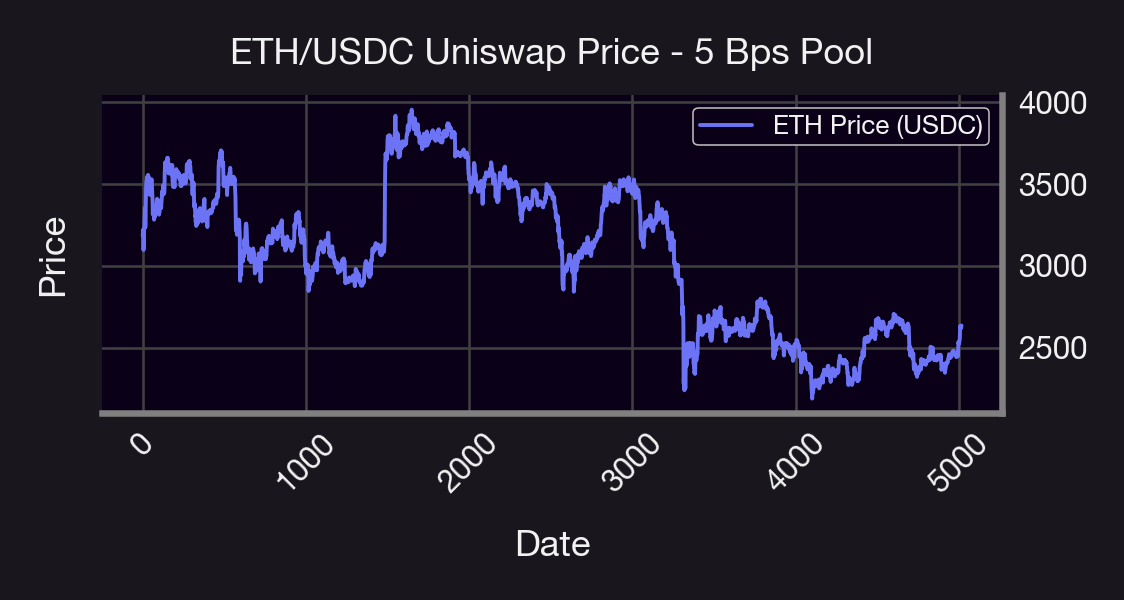

In [13]:
#plot the ETH prices over time
plt.plot(eth_uniswap.index, eth_uniswap.price, label='ETH Price (USDC)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ETH/USDC Uniswap Price - 5 Bps Pool')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### DERIBIT

In [5]:
chosen_currency ='ETH'
resolution = '60'


In [6]:
eth_deribit = Deribit_Options.fetch_eth_price_hourly(start, end, asset=chosen_currency, resolution=resolution)
eth_deribit.set_index('timestamp', inplace=True)
eth_deribit.index=pd.to_datetime(eth_deribit.index)
eth_deribit

,open,high,low,close,volume
timestamp,,,,,
2024-09-30 22:00:00,2610.50,2613.85,2601.40,2602.05,636.402783
2024-09-30 23:00:00,2602.05,2610.05,2576.05,2602.20,2384.448344
2024-10-01 00:00:00,2602.40,2623.00,2590.60,2618.50,2515.447735
2024-10-01 01:00:00,2618.05,2628.50,2616.35,2620.90,2208.681296
2024-10-01 02:00:00,2620.75,2621.00,2607.55,2618.60,2997.328105
...,...,...,...,...,...
2024-11-14 19:00:00,3135.00,3151.70,3130.00,3148.55,1302.574325
2024-11-14 20:00:00,3148.50,3148.50,3095.80,3101.05,5324.465409
2024-11-14 21:00:00,3099.80,3122.75,3083.80,3120.00,3336.566224


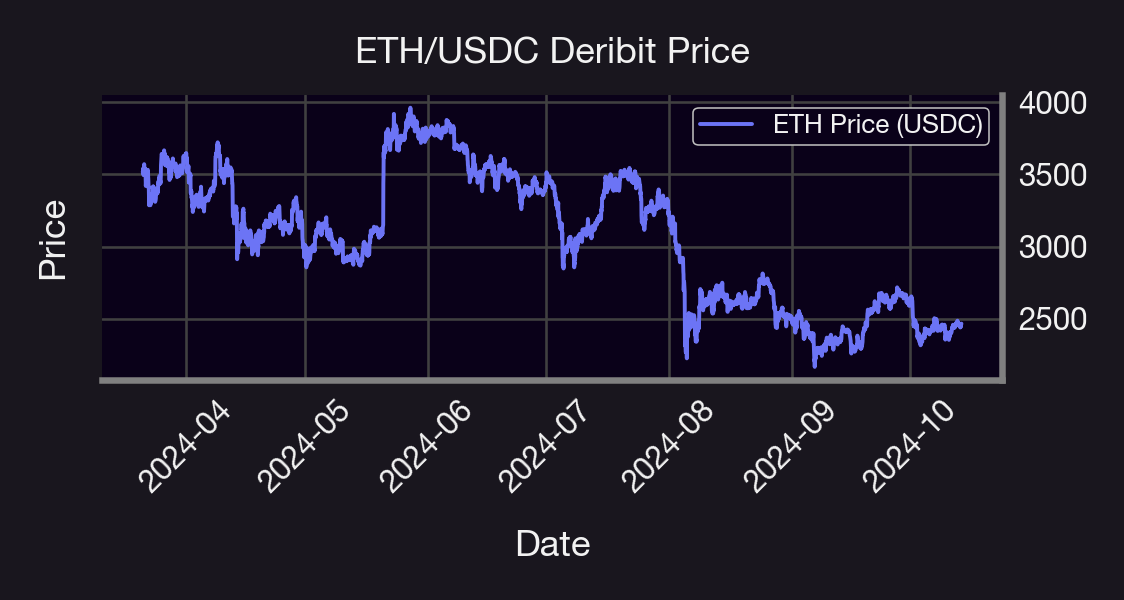

In [10]:
# Optionally, you can plot the ETH prices over time
plt.plot(eth_deribit.index, eth_deribit.close, label='ETH Price (USDC)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ETH/USDC Deribit Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [34]:
# Ensure both dataframes are timezone-naive or timezone-aware with the same time zone
if pd.api.types.is_datetime64tz_dtype(eth_uniswap.index):
    eth_uniswap.index = eth_uniswap.index.tz_convert('UTC')
else:
    eth_uniswap.index = eth_uniswap.index.tz_localize('UTC')

if pd.api.types.is_datetime64tz_dtype(eth_deribit.index):
    eth_deribit.index = eth_deribit.index.tz_convert('UTC')
else:
    eth_deribit.index = eth_deribit.index.tz_localize('UTC')

/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gn/T/ipykernel_19162/1368761498.py:2: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(eth_uniswap.index):
/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gn/T/ipykernel_19162/1368761498.py:7: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(eth_deribit.index):


In [36]:
# Trim both series to the overlapping date range
start_date = max(min(eth_deribit.index), min(eth_uniswap.index))
end_date = min(max(eth_uniswap.index), max(eth_deribit.index))
print(start_date, end_date)

2024-03-20 23:00:00+00:00 2024-10-13 22:00:00+00:00


In [63]:
# Crop according to the common start and end between the two dataframe eth_uniswap and eth_deribit
eth_uniswap_cut = eth_uniswap.loc[start_date:end_date]
eth_deribit_cut = eth_deribit.loc[start_date:end_date]

In [62]:
# Calculate the average price of the two series
average_price = (eth_uniswap_cut.price.mean() + eth_deribit_cut.close.mean()) / 2

# Test the paires sample t-test and the pearson correlation between deribit ETH price and Uniswap price
t_stat, p_value_ttest = stats.ttest_rel(eth_uniswap_cut.price, eth_deribit_cut.close)
print("Paired Sample t-test:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value_ttest:.3e}")

pearson_corr, p_value_pearson = stats.pearsonr(eth_uniswap_cut.price, eth_deribit_cut.close)
print(f"\nPearson Correlation Coefficient: {pearson_corr:.3f}, p-value: {p_value_pearson:.3e}")

Paired Sample t-test:
t-statistic: -1.969, p-value: 4.902e-02

Pearson Correlation Coefficient: 1.000, p-value: 0.000e+00


In [41]:
t_stat, p_value_ttest = stats.ttest_rel(eth_uniswap_cut.price, eth_deribit_cut.close)
print("Paired Sample t-test:")
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value_ttest:.3e}")

Paired Sample t-test:
t-statistic: -1.969, p-value: 4.902e-02


In [61]:

# Ensure both dataframes are aligned and have the same length
deribit_common, uniswap_common = eth_uniswap_cut.price.align(eth_deribit_cut.close, join='inner')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(list(deribit_common), list(uniswap_common))

# Convert MAE to percentage
mae_percentage = (mae / np.mean(list(deribit_common))) * 100

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"MAE as a Percentage: {mae_percentage:.3f}%")

Mean Absolute Error (MAE): 6.972978237122508
MAE as a Percentage: 0.227%


## IV DATA: Uniswap VS Deribit

In [ ]:
deribit = Deribit_Options(currency=chosen_currency,start=start, end=end)
df_deribit_iv = deribit.dvol_test(currency=chosen_currency,start = start, end = end, resolution = resolution)
df_deribit_iv.set_index('timestamp', inplace=True)
df_deribit_iv

In [ ]:
# Here if we want to fetch the iv data from uniswap 
uniswap_iv = pool_data.data.iv*100
uniswap_iv = pd.DataFrame(uniswap_iv)

In [ ]:
uniswap_iv_hoursly = uniswap_iv.resample('H').mean()

In [87]:
# Here we already have df_merged that contains hourly data of both Dvol and uniswap IV merged together on the smae timestamp
df_merged = pd.read_csv('df_merged.csv')
df_merged.drop(columns='Unnamed: 0', inplace=True)
df_merged.dropna(inplace=True)
df_merged['timestamp']=pd.to_datetime(df_merged['timestamp'])

In [88]:
df_merged.set_index('timestamp', inplace=True)

In [89]:
df_merged

,iv_uniswap,iv_dvol,iv_dvol_norm,iv_uniswap_norm,iv_dvol_fd,iv_uniswap_fd
timestamp,,,,,,
2024-04-28 15:00:00,52.453540,63.03,0.295655,0.122849,-0.378655,-2.333947
2024-04-28 16:00:00,51.599304,62.93,0.292616,0.120649,-0.226740,10.026628
2024-04-28 17:00:00,51.357372,63.59,0.312671,0.120025,-0.094058,4.180476
2024-04-28 18:00:00,51.623935,64.04,0.326345,0.120712,0.723739,3.117042
2024-04-28 19:00:00,49.737082,64.04,0.326345,0.115852,0.928715,2.974539
...,...,...,...,...,...,...
2024-10-14 18:00:00,53.826058,64.51,0.340626,0.126384,1.190358,5.938507
2024-10-14 19:00:00,55.238504,64.35,0.335764,0.130022,1.251538,5.041879
2024-10-14 20:00:00,56.215255,64.51,0.340626,0.132537,1.134061,5.866412


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gn/T/ipykernel_19162/1707060789.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


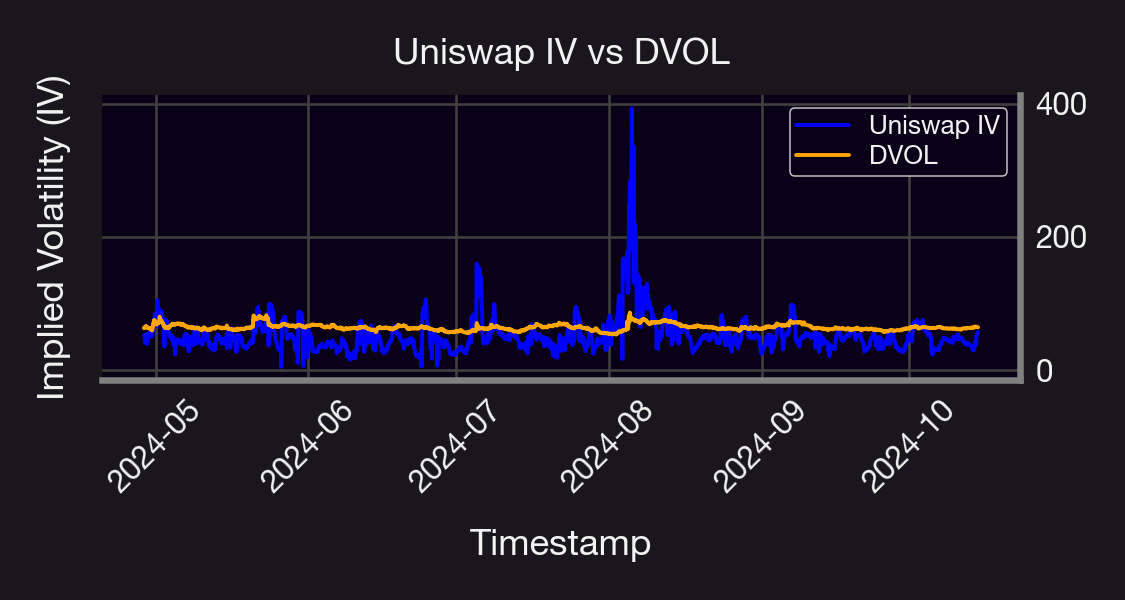

In [91]:
plt.plot(df_merged.index, df_merged['iv_uniswap'], label='Uniswap IV', color='blue')
plt.plot(df_merged.index, df_merged['iv_dvol'], label='DVOL', color='orange')

plt.xlabel('Timestamp')
plt.ylabel('Implied Volatility (IV)')
plt.title('Uniswap IV vs DVOL')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
# Assuming you have a dataframe df_merged with iv_dvol and iv_uniswap columns
# Normalize both columns to a scale of 0 to 1 for comparison
df_merged['iv_dvol_norm'] = (df_merged['iv_dvol'] - df_merged['iv_dvol'].min()) / (df_merged['iv_dvol'].max() - df_merged['iv_dvol'].min())
df_merged['iv_uniswap_norm'] = (df_merged['iv_uniswap'] - df_merged['iv_uniswap'].min()) / (df_merged['iv_uniswap'].max() - df_merged['iv_uniswap'].min())

In [93]:
df_merged.dropna(inplace= True)


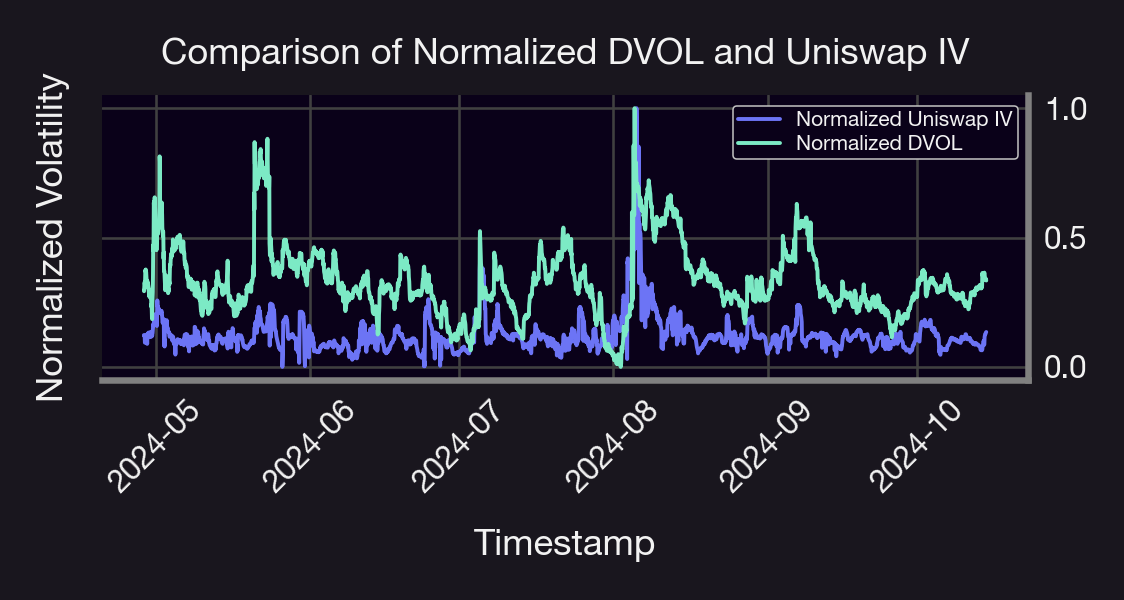

In [94]:
# Plot the normalized values
plt.plot(df_merged.index, df_merged['iv_uniswap_norm'], label='Normalized Uniswap IV')
plt.plot(df_merged.index, df_merged['iv_dvol_norm'], label='Normalized DVOL')

plt.title('Comparison of Normalized DVOL and Uniswap IV')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Volatility')
plt.legend(loc='upper right', fontsize=4)

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Common peaks between Deribit and Uniswap IV

In [95]:
# Function to find high peaks based on a percentile threshold
def find_high_peaks(series, percentile_threshold=95):
    # Find the threshold value at the specified percentile
    threshold_value = series.quantile(percentile_threshold / 100.0)
    
    # Return the series where the values exceed the threshold
    high_peaks = series[series >= threshold_value]
    
    return high_peaks

# Function to find common high peak timestamps
def find_common_peaks(peaks1, peaks2):
    # Find common timestamps where both series have high peaks
    common_timestamps = peaks1.index.intersection(peaks2.index)
    
    return common_timestamps


In [98]:
# Step 1: Find high peaks for Uniswap IV
uniswap_high_peaks = find_high_peaks(df_merged['iv_uniswap'], percentile_threshold=95)

# Step 2: Find high peaks for Deribit Volatility (iv_dvol)
dvol_high_peaks = find_high_peaks(df_merged['iv_dvol'], percentile_threshold=95)

# Step 3: Find common high peak timestamps
common_peak_timestamps = find_common_peaks(uniswap_high_peaks, dvol_high_peaks)

# Step 4: Print the common timestamps
if not common_peak_timestamps.empty:
    print(f"Common high peaks occur at the following timestamps:\n{common_peak_timestamps}")
else:
    print("No common high peaks found between Uniswap IV and DVol.")

Common high peaks occur at the following timestamps:
DatetimeIndex(['2024-05-21 17:00:00', '2024-08-05 01:00:00',
               '2024-08-05 02:00:00', '2024-08-05 03:00:00',
               '2024-08-05 05:00:00', '2024-08-05 06:00:00',
               '2024-08-05 07:00:00', '2024-08-05 08:00:00',
               '2024-08-05 09:00:00', '2024-08-05 10:00:00',
               '2024-08-05 11:00:00', '2024-08-05 12:00:00',
               '2024-08-05 13:00:00', '2024-08-05 14:00:00',
               '2024-08-05 15:00:00', '2024-08-05 16:00:00',
               '2024-08-05 17:00:00', '2024-08-05 18:00:00',
               '2024-08-05 19:00:00', '2024-08-05 20:00:00',
               '2024-08-05 21:00:00', '2024-08-05 22:00:00',
               '2024-08-05 23:00:00', '2024-08-06 00:00:00',
               '2024-08-06 01:00:00', '2024-08-06 02:00:00',
               '2024-08-06 03:00:00', '2024-08-06 04:00:00',
               '2024-08-06 05:00:00', '2024-08-06 06:00:00',
               '2024-08-06 07:00

## Statistical Metrics

In [72]:
# Compute the metrics
metrics = {}

# Mean
metrics['Mean (DVOL)'] = df_merged['iv_dvol'].mean()
metrics['Mean (Uniswap IV)'] = df_merged['iv_uniswap'].mean()

# Standard Deviation
metrics['Standard Deviation (DVOL)'] = df_merged['iv_dvol'].std()
metrics['Standard Deviation (Uniswap IV)'] = df_merged['iv_uniswap'].std()

# Variance
metrics['Variance (DVOL)'] = df_merged['iv_dvol'].var()
metrics['Variance (Uniswap IV)'] = df_merged['iv_uniswap'].var()

# Skewness
metrics['Skewness (DVOL)'] = skew(df_merged['iv_dvol'])
metrics['Skewness (Uniswap IV)'] = skew(df_merged['iv_uniswap'])

# Kurtosis
metrics['Kurtosis (DVOL)'] = kurtosis(df_merged['iv_dvol'])
metrics['Kurtosis (Uniswap IV)'] = kurtosis(df_merged['iv_uniswap'])

# Pearson Correlation
pearson_corr, _ = pearsonr(df_merged['iv_dvol'], df_merged['iv_uniswap'])
metrics['Pearson Correlation'] = pearson_corr

# Spearman Correlation
spearman_corr, _ = spearmanr(df_merged['iv_dvol'], df_merged['iv_uniswap'])
metrics['Spearman Correlation'] = spearman_corr

# Max and Min values
metrics['Max (DVOL)'] = df_merged['iv_dvol'].max()
metrics['Max (Uniswap IV)'] = df_merged['iv_uniswap'].max()
metrics['Min (DVOL)'] = df_merged['iv_dvol'].min()

metrics['Min (Uniswap IV)'] = df_merged['iv_uniswap'].min()

# Granger Causality Test
# Running the Granger Causality test with a lag of 1 for demonstration
granger_result = grangercausalitytests(df_merged[['iv_dvol', 'iv_uniswap']], maxlag=1, verbose=False)
metrics['Granger Causality Test'] = granger_result[1][0]['ssr_ftest'][1]  # p-value of the F-test

# Convert metrics to DataFrame for display
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print(metrics_df)

                                      Value
Mean (DVOL)                       64.156289
Mean (Uniswap IV)                 53.151197
Standard Deviation (DVOL)          4.472173
Standard Deviation (Uniswap IV)   28.470460
Variance (DVOL)                   20.000329
Variance (Uniswap IV)            810.567091
Skewness (DVOL)                    0.917721
Skewness (Uniswap IV)              4.576923
Kurtosis (DVOL)                    1.547696
Kurtosis (Uniswap IV)             34.332401
Pearson Correlation                0.409275
Spearman Correlation               0.315590
Max (DVOL)                        86.210000
Max (Uniswap IV)                 393.013475
Min (DVOL)                        53.300000
Min (Uniswap IV)                   4.756682
Granger Causality Test             0.376785


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## CROSS CORRELATION


Cross-correlation is a measure of similarity between two time series as a function of the time-lag applied to one of them. It helps in identifying whether one time series is related to shifts or delays in another time series, making it a powerful tool in signal processing, finance, and other fields.

### Mathematical Formula

Given two time series, $X$ and $Y$, the cross-correlation $R_{XY}$ at lag $\tau$ is defined as:

$
R_{XY}(\tau) = \frac{\sum_{t=0}^{N-\tau-1} (X_t - \bar{X})(Y_{t+\tau} - \bar{Y})}{\sqrt{\sum_{t=0}^{N-1} (X_t - \bar{X})^2 \sum_{t=0}^{N-1} (Y_t - \bar{Y})^2}}
$

where:
- $X_t$ and $Y_t$ are the values of the two time series at time $t $,
- $\bar{X}$ and $ \bar{Y}$ are the mean values of $X$ and $ Y $,
- $ N $ is the length of the time series,
- $ \tau $ is the time lag applied to $Y$ relative to $X$.

### Explanation

In simple terms, cross-correlation shifts one series in time relative to the other and measures the degree of similarity at each shift. A high positive cross-correlation value indicates a strong positive relationship at a certain lag, while a high negative value indicates a strong negative relationship. By examining cross-correlation, we can detect time-delayed relationships between two variables, which can be useful for forecasting, identifying lead-lag relationships, and other analyses.


In [73]:
# Function to convert the string input into the number of data points to shift
def compute_shift(lag_string, df_frequency):
    # Extract the numeric part and the time unit from the string (e.g., '5D' -> 5 and 'D')
    number = int(lag_string[:-1])  # The numeric part
    unit = lag_string[-1]  # The time unit (D, H, M, etc.)
    
    # Convert the lag into the equivalent number of minutes based on the unit
    if unit == 'D':  # Days
        minutes_per_unit = 24 * 60
    elif unit == 'H':  # Hours
        minutes_per_unit = 60
    elif unit == 'M':  # Months (assuming 30 days per month)
        minutes_per_unit = 30 * 24 * 60
    elif unit == 'Y':  # Years (assuming 365 days per year)
        minutes_per_unit = 365 * 24 * 60
    else:
        raise ValueError("Unsupported time unit. Use 'D' for days, 'H' for hours, 'M' for months, or 'Y' for years.")
    
    # Convert lag into equivalent number of data points based on the frequency of the dataframe
    # Calculate how many minutes are in one row of data (based on the dataframe frequency)
    if df_frequency == 'T':  # Data by the minute
        minutes_per_data_point = 1
    elif df_frequency == 'H':  # Data by the hour
        minutes_per_data_point = 60
    elif df_frequency == 'D':  # Data by the day
        minutes_per_data_point = 24 * 60
    else:
        raise ValueError(f"Unsupported dataframe frequency: {df_frequency}")
    
    # Calculate how many data points to shift
    shift_points = (number * minutes_per_unit) // minutes_per_data_point
    return shift_points

# Cross-Correlation Function that handles time-based shifting using actual timestamps
def cross_correlation_with_custom_lags(lag_max_str, series1, series2, df_frequency):
    # Compute shift for both positive and negative lags
    lag_max_points = compute_shift(lag_max_str, df_frequency)
    lags = np.arange(-lag_max_points, lag_max_points + 1)
    corr = []
    
    for lag in lags:
        # Shift series2 by the computed lag
        shifted_series2 = series2.shift(lag)
        correlation = series1.corr(shifted_series2)
        corr.append(correlation)
        # Add a print statement to explain who leads based on lag
        if lag < 0:
            print(f"At lag {lag} (negative), series1 leads series2 (Deribit Volatility).")
        elif lag > 0:
            print(f"At lag {lag} (positive), series2 leads series1 (Uniswap IV).")
        else:
            print(f"At lag {lag}, the two series are compared at the same time (no lead).")

        
    return lags, corr

In [76]:
# Assuming df_resampled is already the resampled dataframe (by minute, hour, or day)
df_frequency = 'H'  # Set the frequency of the data ('T' for minute, 'H' for hour, 'D' for day)
series1 = df_merged['iv_uniswap']
series2 = df_merged['iv_dvol']

# Compute cross-correlation using a custom lag (e.g., '5D' for 5 days)
lag_max_str = '10D'  # Example input for 10 days
lags_points, corr_values = cross_correlation_with_custom_lags(lag_max_str, series1, series2, df_frequency)

At lag -240 (negative), series1 leads series2 (Deribit Volatility).
At lag -239 (negative), series1 leads series2 (Deribit Volatility).
At lag -238 (negative), series1 leads series2 (Deribit Volatility).
At lag -237 (negative), series1 leads series2 (Deribit Volatility).
At lag -236 (negative), series1 leads series2 (Deribit Volatility).
At lag -235 (negative), series1 leads series2 (Deribit Volatility).
At lag -234 (negative), series1 leads series2 (Deribit Volatility).
At lag -233 (negative), series1 leads series2 (Deribit Volatility).
At lag -232 (negative), series1 leads series2 (Deribit Volatility).
At lag -231 (negative), series1 leads series2 (Deribit Volatility).
At lag -230 (negative), series1 leads series2 (Deribit Volatility).
At lag -229 (negative), series1 leads series2 (Deribit Volatility).
At lag -228 (negative), series1 leads series2 (Deribit Volatility).
At lag -227 (negative), series1 leads series2 (Deribit Volatility).
At lag -226 (negative), series1 leads series2 (D

- Negative lag → Uniswap IV leads (Uniswap IV changes happen first, and Deribit Volatility follows).
- Positive lag → Deribit Volatility leads (Deribit Volatility changes happen first, and Uniswap IV follows).
- Positive correlation means both series move in the same direction.
Negative correlation means they move in opposite directions.
- Zero Lag:At lag 0, the correlation drops back to near zero, indicating that there isn't a strong simultaneous relationship between the two series when comparing them directly without any lag.

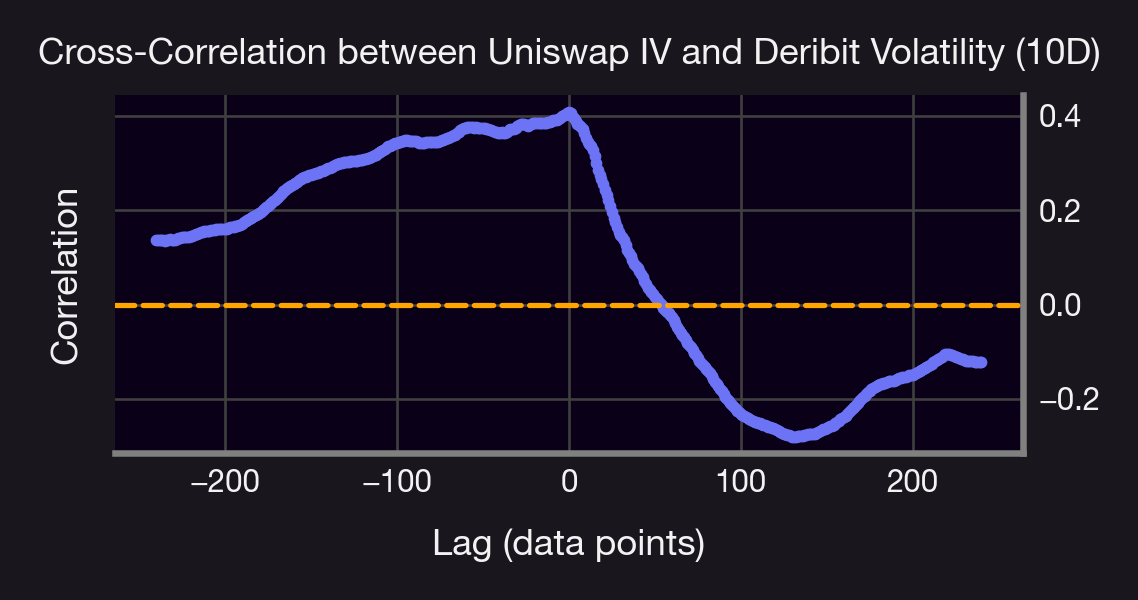

In [77]:
# Plot the cross-correlation function
plt.plot(lags_points, corr_values, marker='o')
plt.title(f'Cross-Correlation between Uniswap IV and Deribit Volatility ({lag_max_str})')
plt.xlabel('Lag (data points)')
plt.ylabel('Correlation')
plt.grid(True)
plt.axhline(0, color='orange', linestyle='--', linewidth=1)
plt.show()

## Cointegration


Cointegration is a statistical property of a collection of time series variables, which indicates that a linear combination of these variables is stationary, even if the individual time series are non-stationary. Cointegration suggests a long-term equilibrium relationship between the variables, which can be useful for understanding relationships in economic or financial data.

### Mathematical Definition

Let $X_t$ and $Y_t$ be two non-stationary time series. If there exists a coefficient $\beta$ such that the linear combination:

$
Z_t = X_t - \beta Y_t
$

is stationary (i.e., $Z_t $ has a constant mean and variance over time), then $ X_t $ and $Y_t $ are said to be cointegrated with cointegrating vector $ (1, -\beta)$.

For a more general case with multiple time series $ Y_t = (Y_{1,t}, Y_{2,t}, \dots, Y_{k,t}) $, there exists a vector $ \beta = (\beta_1, \beta_2, \dots, \beta_k) $ such that:

$
\beta' Y_t = \beta_1 Y_{1,t} + \beta_2 Y_{2,t} + \dots + \beta_k Y_{k,t}
$

is stationary.

### Explanation

Cointegration is particularly useful when modeling relationships between economic or financial variables that may drift over time but tend to move together in the long term. For example, prices of related assets may be individually volatile but maintain a stable relationship over time, indicating cointegration. Detecting cointegration allows analysts to build models that exploit these stable relationships, which can be applied in areas like pairs trading or economic modeling.

In [100]:
iv_uniswap = df_merged['iv_uniswap']
iv_dvol = df_merged['iv_dvol']

# Step 1: Estimate the long-run relationship by regressing iv_dvol on iv_uniswap
X = sm.add_constant(iv_uniswap)  # Add a constant to the model
model = sm.OLS(iv_dvol, X)
results = model.fit()

# Print the regression coefficient
print("Cointegration Coefficient (slope):", results.params[1])

# Step 2: Perform the cointegration test using Engle-Granger
coint_result = coint(iv_dvol, iv_uniswap)
test_statistic, p_value, _ = coint_result

# Output the results of the cointegration test
print("Cointegration Test Statistic:", test_statistic)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("The series iv_uniswap and iv_dvol are cointegrated.")
else:
    print("The series iv_uniswap and iv_dvol are not cointegrated.")

Cointegration Coefficient (slope): 0.06428938629258042
Cointegration Test Statistic: -4.344960417145131
P-value: 0.00217664225235093
The series iv_uniswap and iv_dvol are cointegrated.


/var/folders/r8/xfxg_lnj0l1444yjhxcv5dpc0000gn/T/ipykernel_19162/9168653.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Cointegration Coefficient (slope):", results.params[1])


## VAR

The Vector Autoregression (VAR) model is a statistical model used to capture the linear interdependencies among multiple time series. Unlike univariate autoregressive models, VAR allows multiple time series to influence each other. This model is commonly used in econometrics and finance to analyze dynamic relationships between time series variables.

### Mathematical Formulation

For a VAR model of order $p$ (VAR$p$), with $ k $ variables, the system of equations can be represented as:

$
Y_t = c + A_1 Y_{t-1} + A_2 Y_{t-2} + \dots + A_p Y_{t-p} + \epsilon_t
$

where:
- $ Y_t $ is a $ k \times 1 $ vector of time series values at time $t $,
- $ c $ is a $ k \times 1 $ vector of constants,
- $A_i $ are $ k \times k $ coefficient matrices for each lag $i $ (from 1 to $ p $),
- $ \epsilon_t $ is a $ k \times 1 $ vector of error terms at time $t $, assumed to be white noise.

### Explanation

In the VAR model, each variable in the system is modeled as a linear function of past values of itself and past values of all other variables in the system. By including multiple time series and their lags, the VAR model can capture complex interdependencies, making it useful for forecasting and understanding multivariate time series dynamics.


In [102]:
def fractional_difference(series, d, thresh=1e-5):
    """Perform fractional differencing on a time series."""
    weights = [1]
    for k in range(1, len(series)):
        weights.append(-weights[-1] * (d - k + 1) / k)
        if abs(weights[-1]) < thresh:
            break
    weights = np.array(weights[::-1]).reshape(-1, 1)
    
    # Apply the weights to the series
    fractionally_differenced = []
    for i in range(len(weights), len(series)):
        window = series[i - len(weights):i]
        fractionally_differenced.append(np.dot(weights.T, window)[0])
    return pd.Series(fractionally_differenced, index=series.index[len(weights):])

In [103]:
# Assume df_merged is the DataFrame with columns 'iv_dvol' and 'iv_uniswap'
d_order = 0.5  # Fractional order of integration, based on article of Nathan
# Fractionally difference (fd) both time series
df_merged['iv_dvol_fd'] = fractional_difference(df_merged['iv_dvol'].dropna(), d_order)
df_merged['iv_uniswap_fd'] = fractional_difference(df_merged['iv_uniswap'].dropna(), d_order)

# Combine the fractionally differenced series and drop NaN values
df_fd = df_merged[['iv_dvol_fd', 'iv_uniswap_fd']].dropna()

In [104]:
# Fit a VAR model on the fractionally differenced data
model = VAR(df_fd)
results = model.fit(maxlags=1)  # Adjust lag based on AIC/BIC criteria as needed
# Print the summary of the model to examine parameters
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Nov, 2024
Time:                     02:28:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.10409
Nobs:                     3135.00    HQIC:                   3.09667
Log likelihood:          -13738.3    FPE:                    22.0323
AIC:                      3.09251    Det(Omega_mle):         21.9902
--------------------------------------------------------------------
Results for equation iv_dvol_fd
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.378715         0.018840           20.102           0.000
L1.iv_dvol_fd            0.670884         0.013623           49.248           0.000
L1.iv_uniswap_fd         0.002501         0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
